**Sobre o Conjunto de Dados**: O conjunto de dados `Medical Cost Personal Datasets`, também conhecido como Insurance Dataset, é um dos exemplos clássicos usados no livro "Machine Learning with R" de Brett Lantz, e também amplamente utilizado em tutoriais de regressão. Ele contém informações sobre despesas médicas pessoais cobradas por seguradoras de saúde, com o objetivo de prever o custo do seguro com base em características pessoais.

**Créditos e Mais informações**:

*   [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance)


# Importando o conjunto de dados e bibliotecas 🎲



In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [137]:
data = pd.read_csv('insurance.csv')warnings.filterwarnings('ignore')



- `age`: Idade do beneficiário.
- `sex`: Sexo, (feminino, masculino).
- `bmi`: Índice de massa corporal.
- `children`: Número de filhos cobertos pelo plano.
- `smoker`: Se a pessoa é fumante (sim ou não).
- `region`: A área residencial do beneficiário nos EUA: nordeste, sudeste, sudoeste, noroeste.


- `charges`: Despesas médicas individuais cobradas pelo seguro de saúde. Custo real do seguro.



---



# Análise Exploratória (EDA) 🔍

In [138]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [139]:
# Verificando a presença de valores nulos, e tipos de dados
data.isnull().sum(), data.dtypes

(age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64,
 age           int64
 sex          object
 bmi         float64
 children      int64
 smoker       object
 region       object
 charges     float64
 dtype: object)

In [140]:
data.describe() # Estatísticas descritivas das variáveis numéricas

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: xlabel='age', ylabel='Count'>

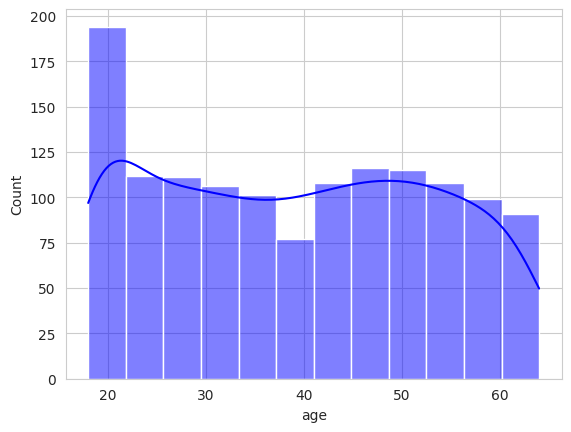

In [141]:
sns.histplot(data.age, kde=True, color='blue')

<Axes: xlabel='age'>

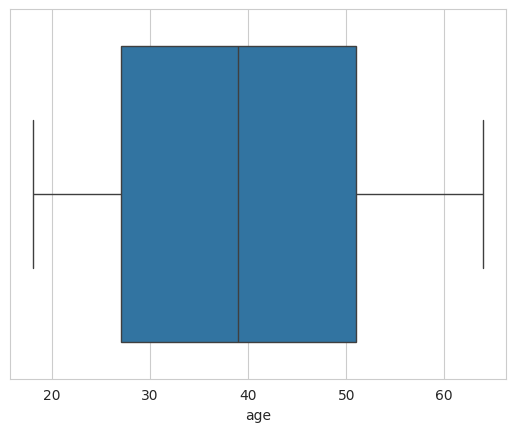

In [142]:
sns.boxplot(data.age, orient='h')

In [143]:
data['sex'].value_counts() # Quantidade de amostras por sexo

,count
sex,
male,676
female,662


<Axes: xlabel='bmi', ylabel='Count'>

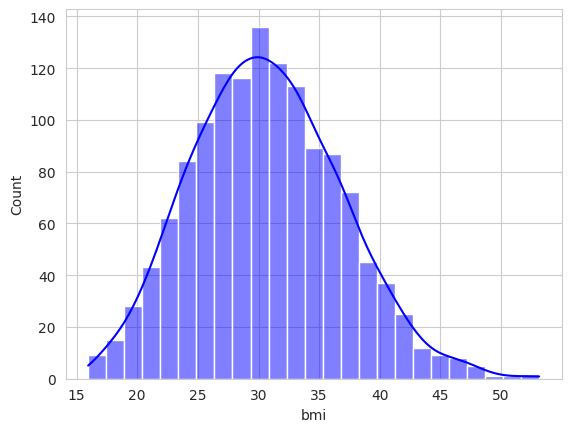

In [144]:
sns.histplot(data.bmi, kde=True, color='blue')

<Axes: xlabel='bmi'>

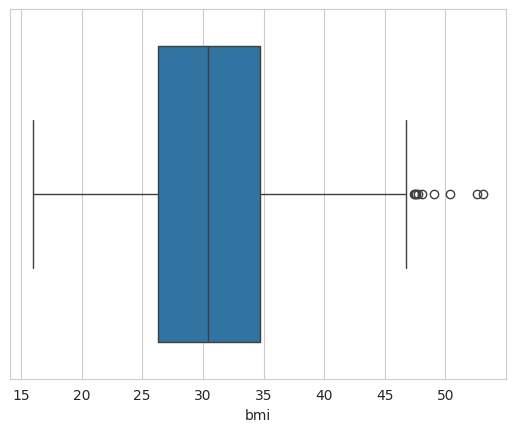

In [145]:
sns.boxplot(data.bmi, orient='h')

<Axes: xlabel='children', ylabel='Count'>

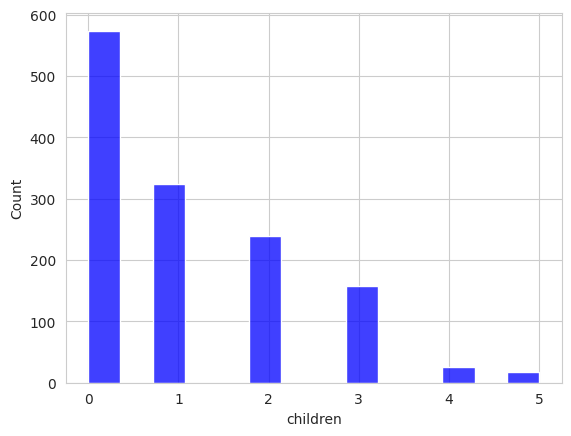

In [146]:
sns.histplot(data.children, color='blue')

In [147]:
data['children'].value_counts() # Quantidade de amostras por quantidade de filhos

,count
children,
0,574
1,324
2,240
3,157
4,25
5,18


In [148]:
data['smoker'].value_counts() # Quantidade de amostras pela condição de fumante (sim, não)

,count
smoker,
no,1064
yes,274


<Axes: xlabel='region', ylabel='Count'>

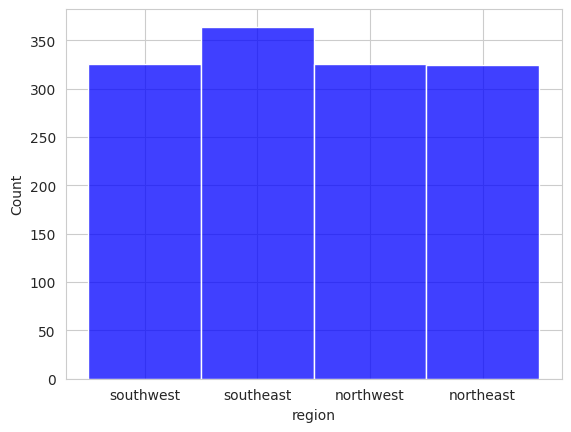

In [149]:
sns.histplot(data.region, color='blue')

In [150]:
data['region'].value_counts() # Quantidade de amostras por região dos EUA

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


<Axes: xlabel='charges', ylabel='Count'>

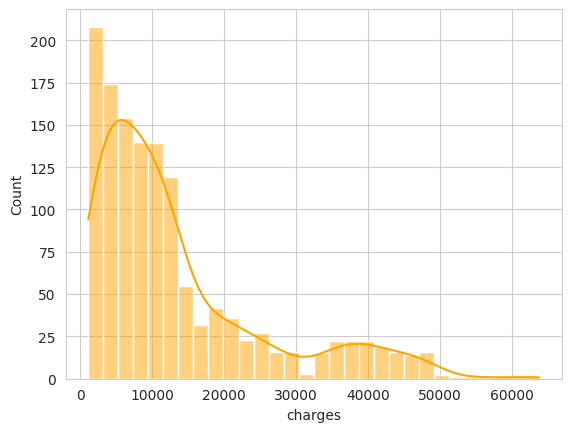

In [151]:
sns.histplot(data['charges'], kde=True, color='orange') # Distribuição da variável alvo

<Axes: xlabel='charges', ylabel='Count'>

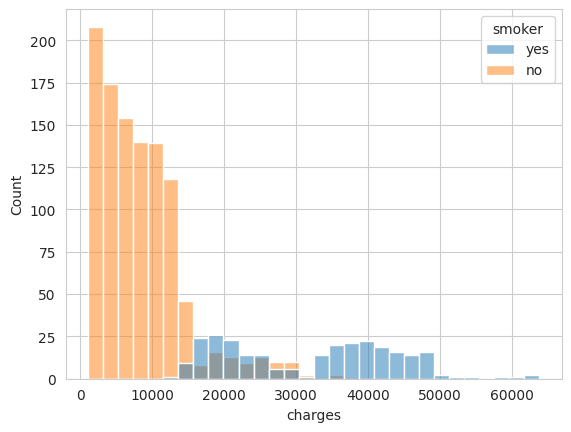

In [152]:
sns.histplot(data=data, x='charges', hue='smoker') # Distribuição da variável alvo por categoria de fumo

<Axes: xlabel='charges'>

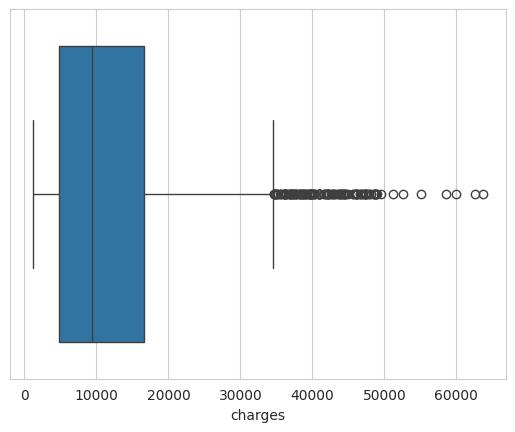

In [153]:
sns.boxplot(data.charges, orient='h')



---



Transformando variáveis categóricas em numéricas para, posteriormente, utilizá-las na criação de gráficos de dispersão e modelos de machine learning:


In [154]:
encod = LabelEncoder()
data['sex'] = encod.fit_transform(data['sex'])
print(encod.classes_, ' transformado em -> 0, 1')
data['smoker'] = encod.fit_transform(data['smoker'])
print(encod.classes_, ' ...-> 0, 1')
data['region'] = encod.fit_transform(data['region'])
print(encod.classes_, ' ...-> 0, 1, 2, 3')

['female' 'male']  transformado em -> 0, 1
['no' 'yes']  ...-> 0, 1
['northeast' 'northwest' 'southeast' 'southwest']  ...-> 0, 1, 2, 3


In [155]:
data.head(1) # Exemplo de uma amostra transformada

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.9,0,1,3,16884.924




---



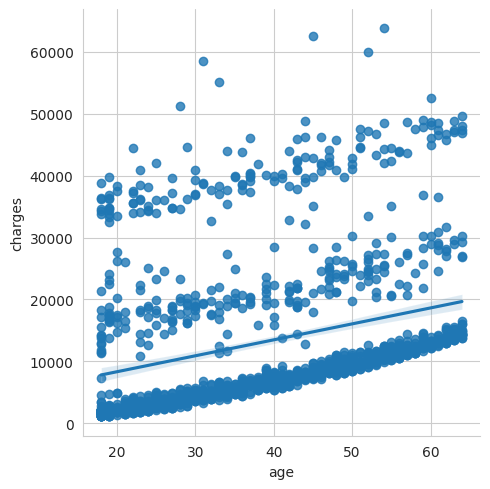

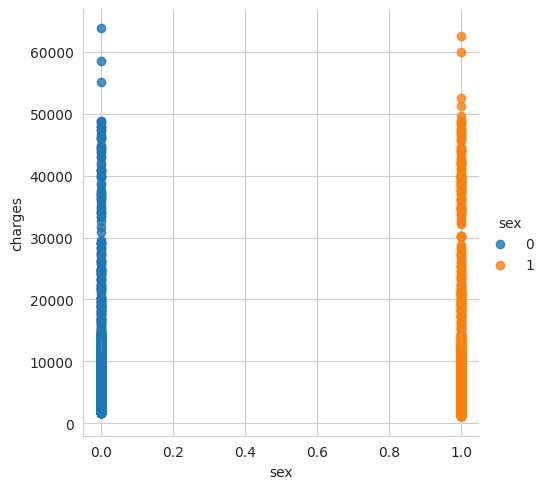

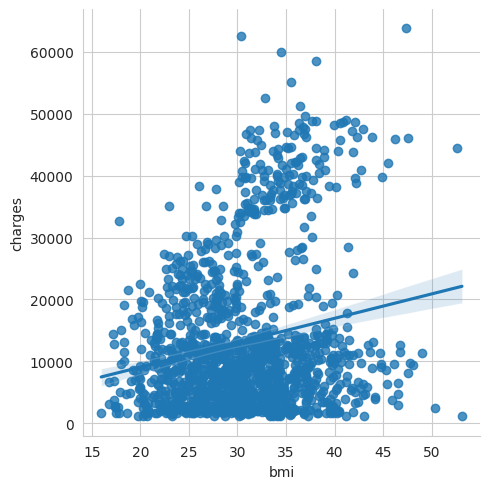

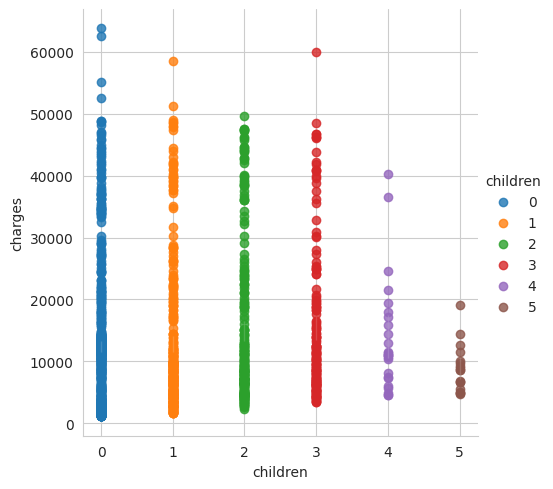

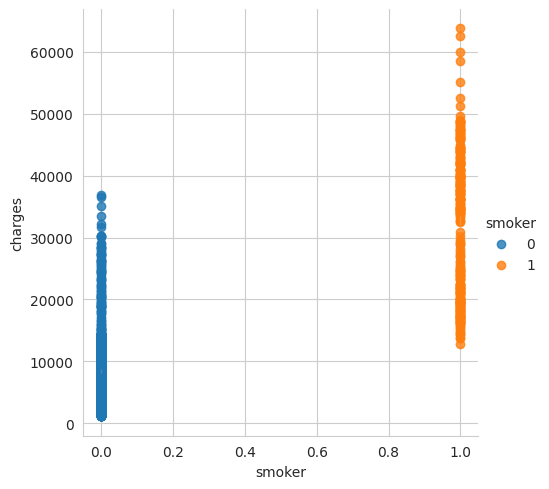

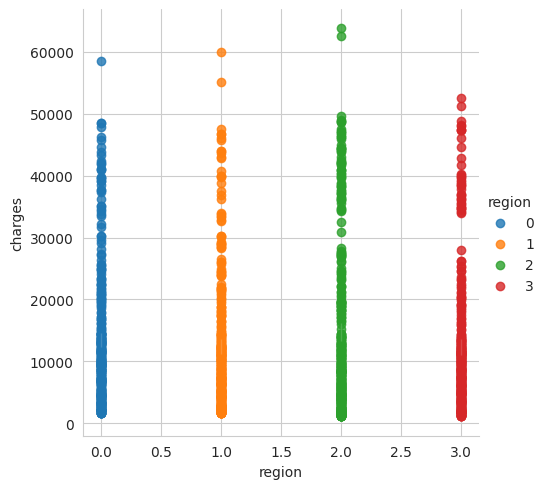

In [156]:
for c in data.columns: # Iteração para criar gráficos de relação e dispersão entre variáveis preditoras e alvo
  v = c
  if c in ['age', 'bmi', 'charges']:
    v = None
  if c in ['charges']:
    continue
  sns.lmplot(data=data, x=c, y='charges', hue=v)
  plt.show()



---



Análise de normalidade e correlação entre variáveis:

É indiscutível que a variável alvo não segue uma distribuição normal, como fica evidente no histograma gerado no inicio da análise. No entanto,  para auxiliar na escolha do tipo de correlação a ser aplicada, realizarei o teste de Shapiro-Wilk para verificar a normalidade das variáveis.

Text(0.5, 1.0, 'Q-Q Plot')

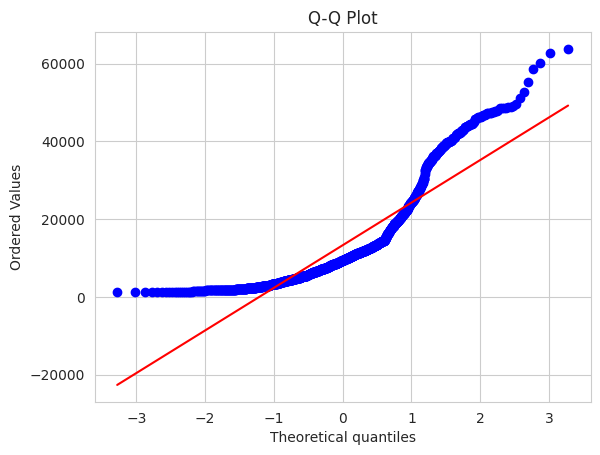

In [157]:
stats.probplot(data['charges'], dist='norm', plot=plt) # Análise de normalidade da variável alvo
plt.title('Q-Q Plot')

Teste de Hipótese:


*   `Ho = DISTRIBUIÇÃO NORMAL: p > 0,05`
*   `Ha = DISTRIBUIÇÃO NÃO-NORMAL: p <= 0,05`





In [158]:
for c in data.columns: # Aplicando o teste shapiro–wilk para cada uma das variáveis
    r = stats.shapiro(data[c])
    print(c, ' -> ', r.pvalue)

age  ->  5.69204692845418e-22
sex  ->  1.4423508345140056e-46
bmi  ->  2.60468368798344e-05
children  ->  5.066436570900864e-36
smoker  ->  7.535159039209903e-52
region  ->  5.879467644959803e-33
charges  ->  1.1505226334932036e-36


In [159]:
data.corr(method='pearson')['charges'].sort_values() # Correlação entre variáveis preditoras e alvo - método pearson

,charges
region,-0.006208
sex,0.057292
children,0.067998
bmi,0.198341
age,0.299008
smoker,0.787251
charges,1.000000




---



# Modelo de Regressão Linear Simples 📈

Criando dois modelos simples de regressão linear para prever o valor do seguro em função da idade e categoria de fumo.


In [160]:
x_age = data['age'].values # Separando e armazenando a variável 'age'
y = data['charges'].values # Variável alvo

In [161]:
# Separação dos dados para treinamento e teste do modelo (seguindo a distribuição 80-20%)
x_treino, x_teste, y_treino, y_teste = train_test_split(x_age.reshape(-1, 1), y, test_size=0.2, random_state=0)

In [162]:
print(x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape)

(1070, 1) (268, 1) (1070,) (268,)


In [163]:
modelo_linear = LinearRegression() # Criação e treinamento do modelo de regressão
modelo_linear.fit(x_treino, y_treino) # Ajuste do modelo com os dados de treino

LinearRegression()

In [164]:
print(modelo_linear.intercept_, # Retornando valores da equação do modelo
      modelo_linear.coef_)

3882.8586788884386 [238.37156961]



Equação da reta de regressão do modelo treinado:
```
y = 3882.85 + 238.37xAGE  
```





* **Coeficiente de determinação (R-Quadrado)**: O quanto da variação da variável dependente (alvo) é explicada pelas variáveis independentes (preditoras) do modelo:




In [165]:
modelo_linear.score(x_treino, y_treino), modelo_linear.score(x_teste, y_teste) # Coeficiente de determinação (para treino e teste)

(0.07859025131404251, 0.12539120236863355)

In [166]:
pred_age = modelo_linear.predict(x_teste) # Alguns valores preditos (os 10 primeiros)

In [167]:
pd.DataFrame(pred_age[0:10])

,0
0,16278.180298
1,15086.322450
2,15324.694020
3,18423.524425
4,16039.808729
5,11987.492046
6,8173.546932
7,16039.808729
8,12940.978324
9,11272.377337




* **Raiz do erro quadrático médio (RMSE)**: Métrica que mede o erro médio entre os valores previstos por um modelo de regressão e os valores reais. Ela indica o tamanho típico do erro que o modelo comete nas suas previsões:



In [168]:
np.sqrt(mean_squared_error(y_teste, pred_age)) # Raiz do erro quadrático médio

np.float64(11797.30753238547)

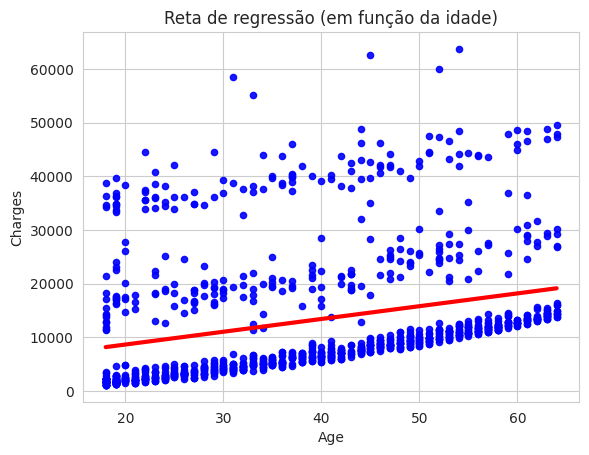

In [169]:
plt.scatter(y=y_treino, x=x_treino, color='blue', s=20, alpha=0.9)
X_plot = np.linspace(18, 64)
plt.plot(X_plot, X_plot*modelo_linear.coef_ + modelo_linear.intercept_, color='r', lw=3)
plt.title('Reta de regressão (em função da idade)')
plt.ylabel('Charges')
plt.xlabel('Age')
plt.show()



---



In [170]:
x_smoker = data['smoker'].values # Separando e armazenando a variável 'smoker'

In [171]:
# Separação dos dados para treinamento e teste do novo modelo
x_treino, x_teste, y_treino, y_teste = train_test_split(x_smoker.reshape(-1, 1), y, test_size=0.2, random_state=0)

In [172]:
modelo_linear = LinearRegression() # Criação e treinamento do modelo
modelo_linear.fit(x_treino, y_treino) # Ajuste do modelo com os dados de treino

LinearRegression()

In [173]:
modelo_linear.score(x_treino, y_treino), modelo_linear.score(x_teste, y_teste) # Coeficiente de determinação

(0.6043205601488244, 0.673429272717778)

In [174]:
pred_smoker = modelo_linear.predict(x_teste)

In [175]:
print(modelo_linear.intercept_, # Retornando valores da equação do modelo
      modelo_linear.coef_)

8479.309357062279 [23070.33693093]




```
y = 8479.30 + 23070.33xSMOKER
```



In [176]:
np.sqrt(mean_squared_error(y_teste, pred_smoker)) # Raiz do erro quadrático médio

np.float64(7208.827056319854)

**O modelo de regressão em função da variável smoker é expressivamente mais eficiente para estimar o valor do seguro. `Smoker` também é a variável preditora de maior correlação com a variável alvo**



---



# Modelo de Regressão Linear Múltipla 📊
Criando modelo de regressão linear para prever o valor do seguro em função de múltiplos atributos


In [177]:
x = data.drop(columns=['charges']).values # Armazenando todos os atributos preditores
y = data['charges'].values # Variável alvo

In [178]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=0)

In [179]:
modelo_linear2 = LinearRegression()
modelo_linear2.fit(x_treino, y_treino)

LinearRegression()

In [180]:
modelo_linear2.score(x_treino, y_treino), modelo_linear2.score(x_teste, y_teste) # Coeficiente de determinação

(0.7368306228430944, 0.7998747145449959)

In [181]:
pred2 = modelo_linear2.predict(x_teste)

In [182]:
print(modelo_linear2.intercept_, # Retornando valores da equação do modelo
      modelo_linear2.coef_)

-11661.983908824403 [  253.99185244   -24.32455098   328.40261701   443.72929547
 23568.87948381  -288.50857254]




```
y = - 11661.98 + 253.99xAGE - 24.32xSEX + 328.40xBMI + 443.72xCHILDREN + 23568.87xSMOKER - 288.50xREGION
```



In [183]:
np.sqrt(mean_squared_error(y_teste, pred2)) # Raiz do erro quadrático médio

np.float64(5643.219748880902)

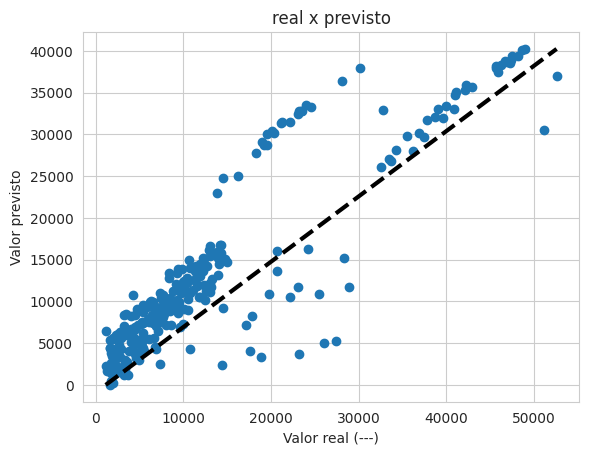

In [184]:
plt.scatter(y_teste, pred2)
plt.xlabel('Valor real (---)')
plt.ylabel('Valor previsto')
plt.title('real x previsto')
plt.plot([y_teste.min(), y_teste.max()], [pred2.min(), pred2.max()], '--', lw=3, color='black')

**A regressão múltipla possibilita o uso de mais variáveis para prever um único valor. Houve melhorias significativas neste modelo de predição em relação ao modelo anterior (simples).**



---



# Predição com Modelo XGBoost 🔥

Criando um modelo com o algoritmo XGBoost (Extreme Gradient Boosting) - baseado em árvore de decisão - para prever o valor do seguro.

In [185]:
model = xgb.XGBRegressor( # Criando e ajustando o modelo
    n_estimators=150,
    max_depth=2,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=0
    )

model.fit(x_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [186]:
model.score(x_treino, y_treino), model.score(x_teste, y_teste) # Coeficiente de determinação

(0.8748424814526804, 0.9033078312667615)

In [187]:
pred = model.predict(x_teste)

In [188]:
np.sqrt(mean_squared_error(y_teste, pred)) # Raiz do erro quadrático médio

np.float64(3922.578382564822)


*   V**alidação Cruzada**: técnica usada para avaliar a capacidade de generalização de um modelo, ou seja, como ele deve se comportar em dados que nunca viu antes.


In [189]:
k = KFold(n_splits=10, shuffle=True, random_state=0) # Validação cruzada

m = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=2,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=0
    )

resultado = cross_val_score(m, x, y, cv=k)
print(resultado)

[0.92180159 0.86322714 0.87916349 0.89978348 0.80587441 0.81219878
 0.87712229 0.85886152 0.84704823 0.79836714]


In [190]:
pd.DataFrame({  # Valores reais e previstos pelo modelo XGBoost
    'Real': y_teste,
    'Previsto': pred
})

,Real,Previsto
0,9724.53000,12352.819336
1,8547.69130,9949.347656
2,45702.02235,46808.363281
3,12950.07120,14640.795898
4,9644.25250,10658.602539
...,...,...
263,15019.76005,17695.593750
264,6664.68595,7539.811523
265,20709.02034,12306.270508
266,40932.42950,40662.503906


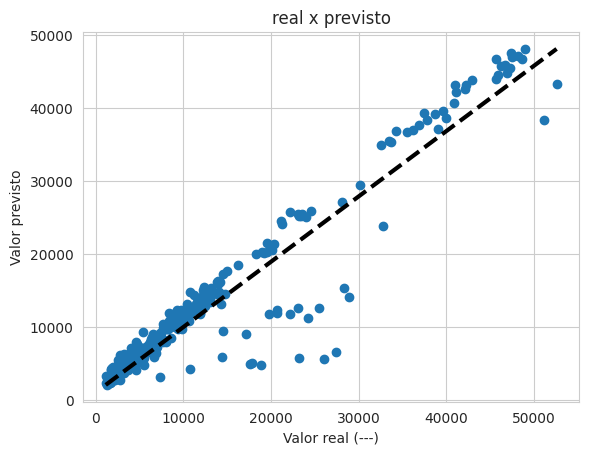

In [191]:
plt.scatter(y_teste, pred)
plt.xlabel('Valor real (---)')
plt.ylabel('Valor previsto')
plt.title('real x previsto')
plt.plot([y_teste.min(), y_teste.max()], [pred.min(), pred.max()], '--', lw=3, color='black')

**O XGBoost se mostrou mais consistente e eficaz na predição dos valores do seguro, além de conseguir captar relações não lineares presentes nos dados.**



---



# Comparativo

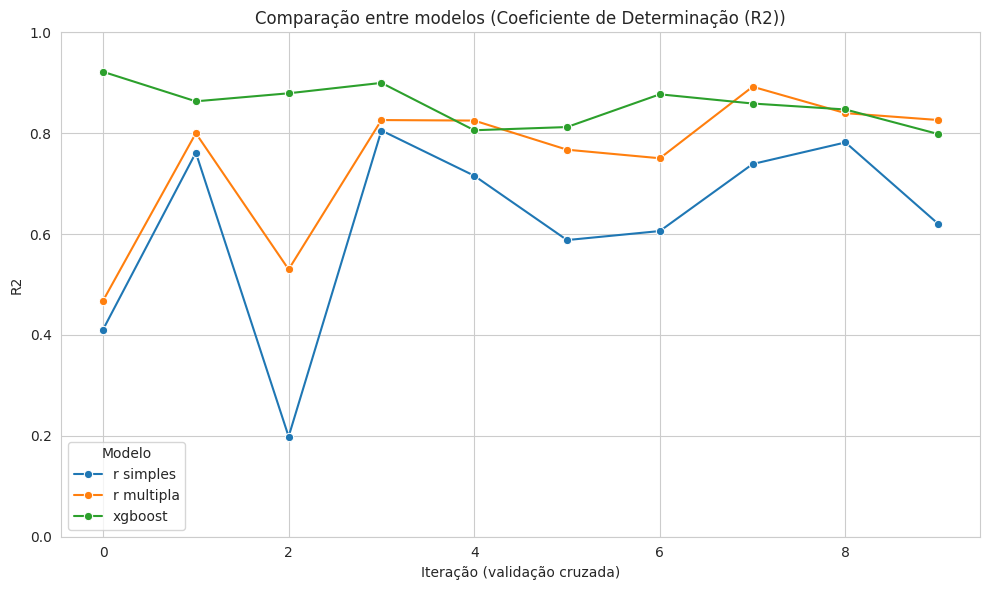

In [192]:
dados_ = {'r simples': [0.41073368, 0.76149714, 0.1985994, 0.80536983, 0.71569263, 0.58815134,
 0.60603632, 0.7388959, 0.78172644, 0.62021819],
      'r multipla': [0.46791769, 0.80001276, 0.53002851, 0.82607, 0.82505462, 0.76732301,
 0.75033051, 0.89215868, 0.83980862, 0.82614467],
      'xgboost': [0.92180159, 0.86322714, 0.87916349, 0.89978348, 0.80587441, 0.81219878,
      0.87712229, 0.85886152, 0.84704823, 0.79836714]}

df = pd.DataFrame(dados_)
df['Iteração (validação cruzada)'] = df.index

df_long = df.melt(id_vars='Iteração (validação cruzada)', var_name='Modelo', value_name='R2')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='Iteração (validação cruzada)', y='R2', hue='Modelo', marker='o')

plt.title('Comparação entre modelos (Coeficiente de Determinação (R2))')
plt.ylabel('R2')
plt.ylim(0, 1.0)
plt.grid(True, axis='y')
plt.legend(title='Modelo')
plt.tight_layout()



---



Text(0, 0.5, 'RMSE')

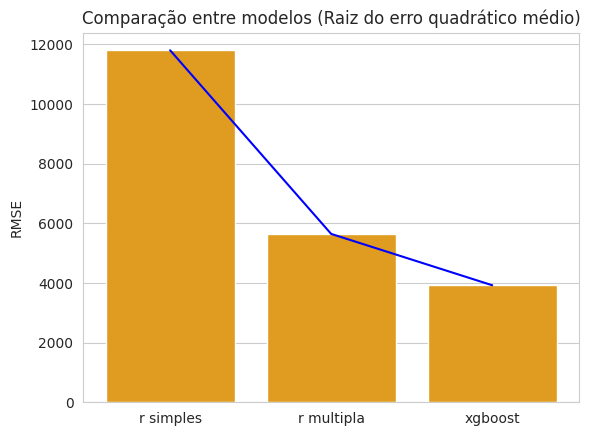

In [193]:
dados_ = {'r simples': 11797.30,
      'r multipla': 5643.21,
      'xgboost': 3922.57}

sns.barplot(x=list(dados_.keys()), y=list(dados_.values()), color='orange')
sns.lineplot(x=list(dados_.keys()), y=list(dados_.values()), color='blue')
plt.title('Comparação entre modelos (Raiz do erro quadrático médio)')
plt.ylabel('RMSE')



---

